In [1]:
!pip install tensorflow numpy matplotlib scikit-learn pillow


In [3]:
import os
print(os.getcwd())

C:\Users\shravya\waste_management


In [11]:
import os

print("Working dir:", os.getcwd())
print("Root contents:", os.listdir('.'))


Working dir: C:\Users\shravya\waste_management
Root contents: ['.ipynb_checkpoints', 'data', 'trashnet-master', 'Untitled.ipynb']


In [13]:
print("Inside trashnet-master:", os.listdir('trashnet-master'))


Inside trashnet-master: ['.gitignore', 'data', 'DataLoader.lua', 'LICENSE', 'model.lua', 'plot.lua', 'README.md', 'shuffle.lua', 'test.lua', 'train.lua', 'utils.lua', 'weight-init.lua']


In [15]:
print("Classes folder:", os.listdir(os.path.join('trashnet-master','data')))


Classes folder: ['constants.py', 'dataset-resized.zip', 'one-indexed-files-notrash_test.txt', 'one-indexed-files-notrash_train.txt', 'one-indexed-files-notrash_val.txt', 'one-indexed-files.txt', 'resize.py', 'zero-indexed-files.txt']


In [19]:
import os, shutil, glob

# 1) Update this to where the six class folders now live:
src_root   = "trashnet-master/data/raw/dataset-resized"
train_root = "data/train"

# 2) Ensure your three target dirs exist
for cls in ("organic","recyclable","hazardous"):
    os.makedirs(os.path.join(train_root, cls), exist_ok=True)

# 3) Define how the original six map to your three
mapping = {
    "organic":    ["paper","cardboard"],
    "recyclable": ["glass","metal","plastic"],
    "hazardous":  ["trash"]
}

# 4) Copy files
for target_cls, folders in mapping.items():
    for folder in folders:
        pattern = os.path.join(src_root, folder, "*")
        for img in glob.glob(pattern):
            shutil.copy(img, os.path.join(train_root, target_cls))

# 5) Verify
print("Done! Counts:")
for cls in mapping:
    cnt = len(os.listdir(os.path.join(train_root, cls)))
    print(f"  {cls:10s}: {cnt} images")


Done! Counts:
  organic   : 997 images
  recyclable: 1393 images
  hazardous : 137 images


In [21]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image


In [23]:
TRAIN_DIR = "data/train"  
IMG_SIZE  = (224, 224)
BATCH_SZ  = 32


In [41]:
import shutil, os

chkpt = os.path.join("data", "train", ".ipynb_checkpoints")
if os.path.isdir(chkpt):
    shutil.rmtree(chkpt)
    print("Removed", chkpt)

print("Now classes:", os.listdir("data/train"))
# should output: ['hazardous','organic','recyclable']


Now classes: ['hazardous', 'organic', 'recyclable']


In [43]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SZ,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SZ,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 2024 images belonging to 3 classes.
Found 504 images belonging to 3 classes.


In [51]:
# Define new callbacks with only ModelCheckpoint (no EarlyStopping)
ft_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_waste_finetuned.keras",
        save_best_only=True,
        monitor="val_accuracy"
    )
]

# Re-compile if you changed trainability
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Re-run fine-tuning for the full 10 epochs
history_finetune = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=ft_callbacks
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 648ms/step - accuracy: 0.8855 - loss: 0.3111 - val_accuracy: 0.9107 - val_loss: 0.2213
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 635ms/step - accuracy: 0.9011 - loss: 0.2785 - val_accuracy: 0.9266 - val_loss: 0.2119
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 619ms/step - accuracy: 0.9134 - loss: 0.2369 - val_accuracy: 0.9127 - val_loss: 0.2327
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 636ms/step - accuracy: 0.9318 - loss: 0.1879 - val_accuracy: 0.9187 - val_loss: 0.2229
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 639ms/step - accuracy: 0.9423 - loss: 0.1788 - val_accuracy: 0.9226 - val_loss: 0.2087
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 633ms/step - accuracy: 0.9449 - loss: 0.1587 - val_accuracy: 0.9028 - val_loss: 0.2573
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 630ms/step - accuracy: 0.9401 - loss: 0.1580 - val_accuracy: 0.8948 - val_loss: 0.2401
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 627ms/step - accuracy: 0.9338 - loss: 0.1647 - val_accu

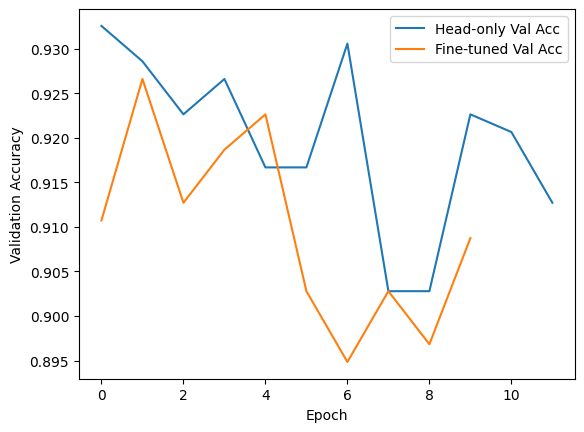

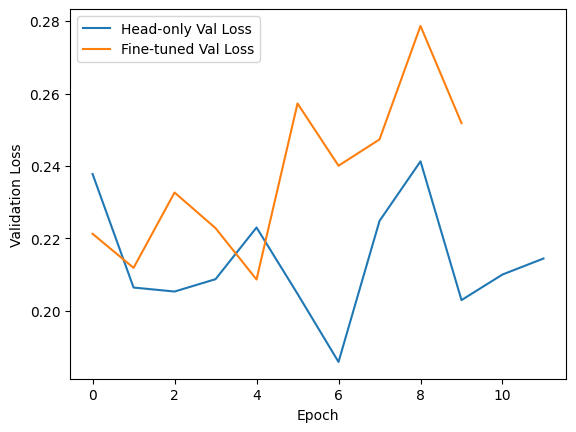

In [53]:
import matplotlib.pyplot as plt

# plot val accuracy
plt.plot(history.history['val_accuracy'],    label='Head-only Val Acc')
plt.plot(history_finetune.history['val_accuracy'], label='Fine-tuned Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Validation Accuracy')
plt.legend(); plt.show()

# plot val loss
plt.plot(history.history['val_loss'],    label='Head-only Val Loss')
plt.plot(history_finetune.history['val_loss'], label='Fine-tuned Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Validation Loss')
plt.legend(); plt.show()


In [55]:
val_gen.reset()
preds = model.predict(val_gen)
y_true = val_gen.classes
y_pred = preds.argmax(axis=1)
labels = list(val_gen.class_indices.keys())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=labels))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step
              precision    recall  f1-score   support

   hazardous       0.45      0.37      0.41        27
     organic       0.98      0.82      0.90       199
  recyclable       0.88      0.99      0.93       278

    accuracy                           0.89       504
   macro avg       0.77      0.73      0.75       504
weighted avg       0.90      0.89      0.89       504

Confusion Matrix:
 [[ 10   1  16]
 [ 12 164  23]
 [  0   2 276]]


In [59]:
import os, glob, random, shutil

# 1. parameters
TRAIN_ROOT = "data/train"
TEST_ROOT  = "data/test"
CLASSES    = ["organic","recyclable","hazardous"]
TEST_RATIO = 0.2  # 20%

# 2. make test folders
for cls in CLASSES:
    os.makedirs(os.path.join(TEST_ROOT, cls), exist_ok=True)

# 3. sample & move
for cls in CLASSES:
    src_dir = os.path.join(TRAIN_ROOT, cls)
    all_imgs = glob.glob(os.path.join(src_dir, "*"))
    n_test   = int(len(all_imgs) * TEST_RATIO)
    test_imgs = random.sample(all_imgs, n_test)
    for img_path in test_imgs:
        shutil.move(img_path, os.path.join(TEST_ROOT, cls))

print("Test split created.")

# 4. confirm
for cls in CLASSES:
    print(f"{cls}: train={len(os.listdir(os.path.join(TRAIN_ROOT,cls)))},",
          f"test={len(os.listdir(os.path.join(TEST_ROOT,cls)))}")


Test split created.
organic: train=798, test=199
recyclable: train=1115, test=278
hazardous: train=111, test=27


In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "data/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SZ,
    class_mode="categorical",
    shuffle=False
)

loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.3f}, Test Loss: {loss:.3f}")


Found 504 images belonging to 3 classes.


C:\Users\shravya\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.8985 - loss: 0.3118
Test Accuracy: 0.946, Test Loss: 0.156


In [63]:
mis_idx = np.where(y_true != y_pred)[0]
for i in mis_idx[:10]:
    print(val_gen.filenames[i], "→", labels[y_pred[i]])


hazardous\trash1.jpg → recyclable
hazardous\trash10.jpg → recyclable
hazardous\trash102.jpg → recyclable
hazardous\trash104.jpg → organic
hazardous\trash107.jpg → recyclable
hazardous\trash108.jpg → recyclable
hazardous\trash109.jpg → recyclable
hazardous\trash11.jpg → recyclable
hazardous\trash110.jpg → recyclable
hazardous\trash111.jpg → recyclable


In [65]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("waste_classifier.tflite","wb").write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\shravya\AppData\Local\Temp\tmpiehuksoz\assets


INFO:tensorflow:Assets written to: C:\Users\shravya\AppData\Local\Temp\tmpiehuksoz\assets


Saved artifact at 'C:\Users\shravya\AppData\Local\Temp\tmpiehuksoz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_313')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1907289404240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289405968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289406160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289405776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289405200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289406544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907292193040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907292193808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289405392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289406928: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

8879796

In [77]:
model.save("waste_classifier_final.keras")  # native Keras format


In [79]:
model.export("waste_classifier_savedmodel_dir")


INFO:tensorflow:Assets written to: waste_classifier_savedmodel_dir\assets


INFO:tensorflow:Assets written to: waste_classifier_savedmodel_dir\assets


Saved artifact at 'waste_classifier_savedmodel_dir'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_313')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1907289404240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289405968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289406160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289405776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289405200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289406544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907292193040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907292193808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289405392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907289406928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1907292193616: 

In [83]:
!dir waste_classifier_final.keras
!dir waste_classifier_savedmodel_dir


 Volume in drive C is Windows
 Volume Serial Number is C65D-9667

 Directory of C:\Users\shravya\waste_management

12-07-2025  07:52 PM        24,541,115 waste_classifier_final.keras
               1 File(s)     24,541,115 bytes
               0 Dir(s)  289,662,132,224 bytes free
 Volume in drive C is Windows
 Volume Serial Number is C65D-9667

 Directory of C:\Users\shravya\waste_management\waste_classifier_savedmodel_dir

12-07-2025  07:53 PM    <DIR>          .
12-07-2025  07:54 PM    <DIR>          ..
12-07-2025  07:53 PM    <DIR>          assets
12-07-2025  07:53 PM                57 fingerprint.pb
12-07-2025  07:53 PM         1,657,972 saved_model.pb
12-07-2025  07:53 PM    <DIR>          variables
               2 File(s)      1,658,029 bytes
               4 Dir(s)  289,662,066,688 bytes free
